In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File paths (adjust if needed)
ANIME_META_FILE = "../content/Anime_data.csv"
RATINGS_FILE = "../content/rating.csv"


In [3]:
# Hyperparameters
RANDOM_SEED = 42
K = 20             # latent factors
LR = 0.01          # learning rate
REG = 0.05         # regularization
EPOCHS = 40        # number of training epochs
TEST_SIZE = 0.15   # validation split
USE_BIAS = True    # use user/item/global biases


In [4]:
# Reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
import pandas as pd
df = pd.read_csv('../content/Anime_data.csv')
df.head(10)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998",https://myanimelist.net/anime/6/Trigun
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002",https://myanimelist.net/anime/7/Witch_Hunter_R...
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005",https://myanimelist.net/anime/8/Bouken_Ou_Beet
5,15,Eyeshield 21,"['Action', 'Sports', 'Comedy', 'Shounen']",Sena is like any other shy kid starting high s...,TV,"['TV Tokyo', 'Nihon Ad Systems', 'TV Tokyo Mus...",['Studio Gallop'],8.05,48765.0,888.0,106468.0,145.0,Manga,"Apr 6, 2005 to Mar 19, 2008",https://myanimelist.net/anime/15/Eyeshield_21
6,16,Hachimitsu to Clover,"['Comedy', 'Drama', 'Josei', 'Romance', 'Slice...","Yuuta, Takumi, and Shinobu share a six-tatami ...",TV,"['Genco', 'Fuji TV', 'Shueisha']",['J.C.Staff'],8.14,54367.0,578.0,160236.0,24.0,Manga,"Apr 15, 2005 to Sep 27, 2005",https://myanimelist.net/anime/16/Hachimitsu_to...
7,17,Hungry Heart: Wild Striker,"['Slice of Life', 'Comedy', 'Sports', 'Shounen']",Kyosuke Kano has lived under the shadow of his...,TV,NaN,['Nippon Animation'],7.69,8868.0,3330.0,16132.0,52.0,Manga,"Sep 11, 2002 to Sep 10, 2003",https://myanimelist.net/anime/17/Hungry_Heart_...
8,18,Initial D Fourth Stage,"['Action', 'Cars', 'Sports', 'Drama', 'Seinen']",Takumi Fujiwara and brothers Keisuke and Ryous...,TV,"['OB Planning', 'Studio Jack']",['A.C.G.T.'],8.24,37575.0,1228.0,64338.0,24.0,Manga,"Apr 17, 2004 to Feb 18, 2006",https://myanimelist.net/anime/18/Initial_D_Fou...
9,19,Monster,"['Drama', 'Horror', 'Mystery', 'Police', 'Psyc...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",TV,"['VAP', 'Shogakukan Productions', 'Nippon Tele...",['Madhouse'],8.69,118553.0,159.0,352153.0,74.0,Manga,"Apr 7, 2004 to Sep 28, 2005",https://myanimelist.net/anime/19/Monster


In [6]:
# Pie chart:

count = df["Type"].value_counts()
count

Type
TV         4775
OVA        3880
Movie      2859
Special    2167
ONA        1504
Music      1144
Unknown      39
Name: count, dtype: int64

/tmp/ipykernel_8312/3956329708.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Type', order=count.index, palette='viridis')


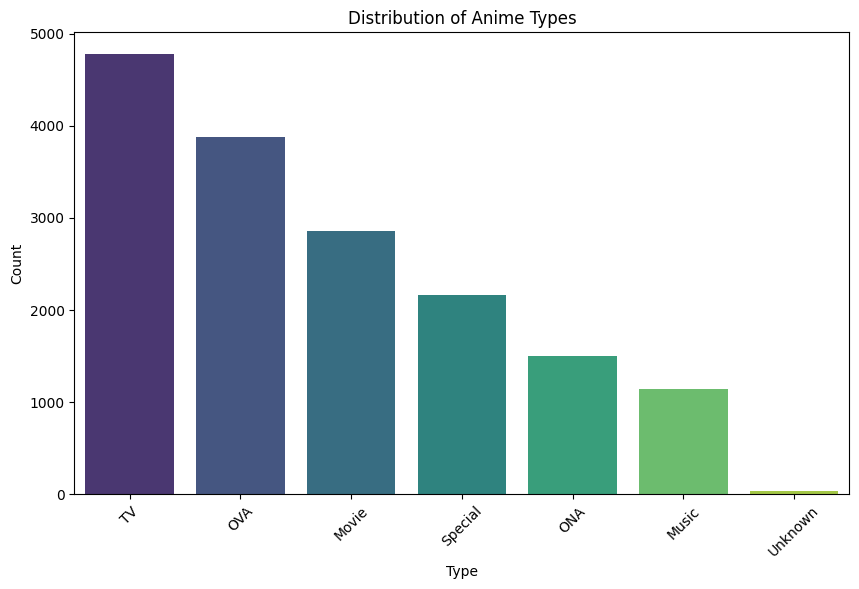

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Type', order=count.index, palette='viridis')
plt.title('Distribution of Anime Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [8]:
print("Loading datasets...")
if not os.path.exists(ANIME_META_FILE):
    raise FileNotFoundError(f"{ANIME_META_FILE} not found. Place the file in working directory.")
if not os.path.exists(RATINGS_FILE):
    raise FileNotFoundError(f"{RATINGS_FILE} not found. Place the file in working directory.")

anime_meta = pd.read_csv(ANIME_META_FILE)
ratings = pd.read_csv(RATINGS_FILE)

print(f"Anime meta rows: {len(anime_meta)}")
print(f"Ratings rows: {len(ratings)}")


Loading datasets...
Anime meta rows: 17002
Ratings rows: 7813737


In [9]:
anime_meta.describe( include='all')



,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
count,17002.000000,17002,14990,15583,16368,7635,7919,14425.000000,1.322700e+04,16368.000000,1.700200e+04,14085.000000,15075,16368,16368
unique,NaN,16737,4577,15194,7,3005,777,NaN,NaN,NaN,NaN,NaN,16,11127,16216
top,NaN,Castlevania,['Hentai'],No synopsis has been added for this series yet...,TV,['NHK'],['Toei Animation'],NaN,NaN,NaN,NaN,NaN,Unknown,Not available,https://myanimelist.net/anime/6025/Battle_Can%...
freq,NaN,17,828,37,4775,426,644,NaN,NaN,NaN,NaN,NaN,3993,295,2
mean,20446.579638,NaN,NaN,NaN,NaN,NaN,NaN,6.287867,1.139084e+04,8131.919599,2.038130e+04,11.482712,NaN,NaN,NaN
std,14342.513259,NaN,NaN,NaN,NaN,NaN,NaN,1.141401,4.328434e+04,4714.683351,7.121404e+04,44.089040,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00,1.000000,0.000000e+00,1.000000,NaN,NaN,NaN
25%,5581.500000,NaN,NaN,NaN,NaN,NaN,NaN,5.620000,4.300000e+01,4042.500000,1.450000e+02,1.000000,NaN,NaN,NaN
50%,21334.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.410000,4.780000e+02,8115.000000,1.113000e+03,1.000000,NaN,NaN,NaN
75%,34789.250000,NaN,NaN,NaN,NaN,NaN,NaN,7.090000,3.831000e+03,12208.250000,7.855750e+03,12.000000,NaN,NaN,NaN


In [10]:
anime_meta.head(10)


,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998",https://myanimelist.net/anime/6/Trigun
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002",https://myanimelist.net/anime/7/Witch_Hunter_R...
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005",https://myanimelist.net/anime/8/Bouken_Ou_Beet
5,15,Eyeshield 21,"['Action', 'Sports', 'Comedy', 'Shounen']",Sena is like any other shy kid starting high s...,TV,"['TV Tokyo', 'Nihon Ad Systems', 'TV Tokyo Mus...",['Studio Gallop'],8.05,48765.0,888.0,106468.0,145.0,Manga,"Apr 6, 2005 to Mar 19, 2008",https://myanimelist.net/anime/15/Eyeshield_21
6,16,Hachimitsu to Clover,"['Comedy', 'Drama', 'Josei', 'Romance', 'Slice...","Yuuta, Takumi, and Shinobu share a six-tatami ...",TV,"['Genco', 'Fuji TV', 'Shueisha']",['J.C.Staff'],8.14,54367.0,578.0,160236.0,24.0,Manga,"Apr 15, 2005 to Sep 27, 2005",https://myanimelist.net/anime/16/Hachimitsu_to...
7,17,Hungry Heart: Wild Striker,"['Slice of Life', 'Comedy', 'Sports', 'Shounen']",Kyosuke Kano has lived under the shadow of his...,TV,NaN,['Nippon Animation'],7.69,8868.0,3330.0,16132.0,52.0,Manga,"Sep 11, 2002 to Sep 10, 2003",https://myanimelist.net/anime/17/Hungry_Heart_...
8,18,Initial D Fourth Stage,"['Action', 'Cars', 'Sports', 'Drama', 'Seinen']",Takumi Fujiwara and brothers Keisuke and Ryous...,TV,"['OB Planning', 'Studio Jack']",['A.C.G.T.'],8.24,37575.0,1228.0,64338.0,24.0,Manga,"Apr 17, 2004 to Feb 18, 2006",https://myanimelist.net/anime/18/Initial_D_Fou...
9,19,Monster,"['Drama', 'Horror', 'Mystery', 'Police', 'Psyc...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",TV,"['VAP', 'Shogakukan Productions', 'Nippon Tele...",['Madhouse'],8.69,118553.0,159.0,352153.0,74.0,Manga,"Apr 7, 2004 to Sep 28, 2005",https://myanimelist.net/anime/19/Monster


In [11]:
ratings.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [16]:
ratings.describe( include='all')

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [18]:
ratings.info()

anime_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17002 entries, 0 to 17001
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Anime_id    17002 non-null  int64  
 1   Title       17002 non-null  object 
 2   Genre       14990 non-null  object 
 3   Synopsis    15583 non-null  object 
 4   Type        16368 non-null  object 
 5   Producer    7635 non-null   object 
 6   Studio      7919 non-null   object 
 7   Rating      14425 non-null  float64
 8   ScoredBy    13227 non-null  float64
 9   Popularity  16368 non-null  float64
 10  Members     17002 non-null  float64
 11  Episodes    14085 non-null  float64
 12  Source      15075 non-null  object 
 13  Aired       16

In [15]:

# # Keep minimal anime meta: Anime_id, Title
# if 'Anime_id' not in anime_meta.columns:
#     # try different column name variations
#     possible = [c for c in anime_meta.columns if 'id' in c.lower() and 'anime' in c.lower()]
#     if possible:
#         anime_meta.rename(columns={possible[0]: 'Anime_id'}, inplace=True)
#     else:
#         raise ValueError("Anime metadata must contain 'Anime_id' column.")
# anime_meta = anime_meta[['Anime_id', 'Title']].drop_duplicates().reset_index(drop=True)
# anime_meta['Anime_id'] = anime_meta['Anime_id'].astype(int)


In [12]:
# Ratings expected columns: user_id, anime_id, rating
required_cols = ['user_id', 'anime_id', 'rating']
for c in required_cols:
    if c not in ratings.columns:
        raise ValueError(f"Ratings file must contain column '{c}'. Found columns: {list(ratings.columns)}")


In [13]:
# Missing values handling & basic cleaning
print("\nMissing values before cleaning (ratings):")
print(ratings.isnull().sum())


Missing values before cleaning (ratings):
user_id     0
anime_id    0
rating      0
dtype: int64


In [14]:
print("\nMissing values before cleaning (anime_meta):")
print(anime_meta.isnull().sum())


Missing values before cleaning (anime_meta):
Anime_id         0
Title            0
Genre         2012
Synopsis      1419
Type           634
Producer      9367
Studio        9083
Rating        2577
ScoredBy      3775
Popularity     634
Members          0
Episodes      2917
Source        1927
Aired          634
Link           634
dtype: int64


In [19]:
# Drop rows with missing user_id/anime_id/rating
ratings = ratings.dropna(subset=['user_id','anime_id','rating']).copy()
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['anime_id'] = ratings['anime_id'].astype(int)

print("\nAfter dropping NA, ratings shape:", ratings.shape)
print("Rating min/max:", ratings['rating'].min(), ratings['rating'].max())



After dropping NA, ratings shape: (7813737, 3)
Rating min/max: -1 10


In [20]:
# Assuming ratings are on 1-10 scale; but don't force if different. If out of bounds, clip.
if ratings['rating'].min() < 0 or ratings['rating'].max() > 10:
    print("Ratings appear outside 0-10 range. Clipping to [0,10].")
    ratings['rating'] = ratings['rating'].clip(0,10)


Ratings appear outside 0-10 range. Clipping to [0,10].


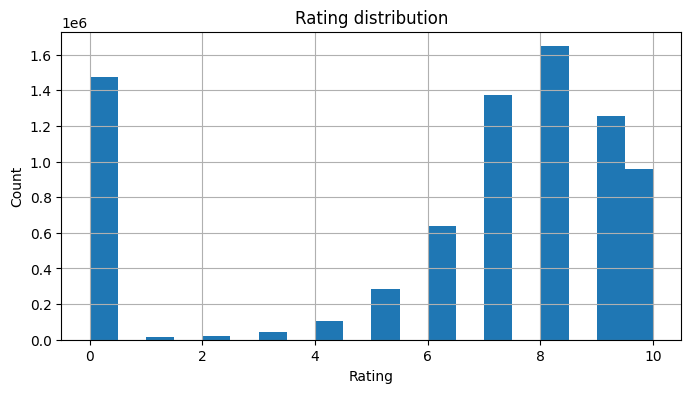

In [21]:
# Rating distribution

plt.figure(figsize=(8,4))
plt.hist(ratings['rating'], bins=20)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

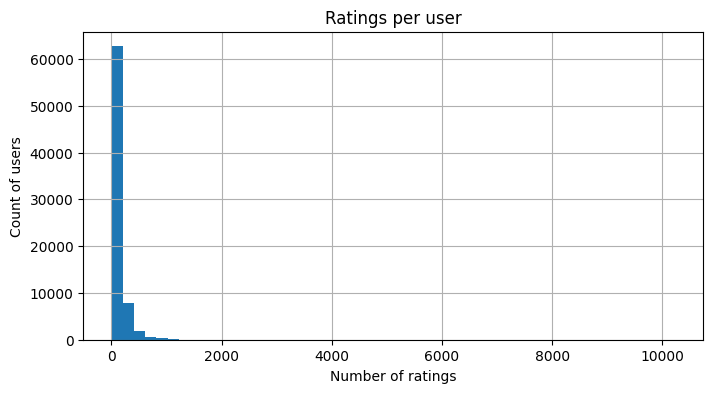

In [22]:
# Ratings per user distribution
ratings_per_user = ratings.groupby('user_id').size()
plt.figure(figsize=(8,4))
plt.hist(ratings_per_user, bins=50)
plt.title("Ratings per user")
plt.xlabel("Number of ratings")
plt.ylabel("Count of users")
plt.grid(True)
plt.show()

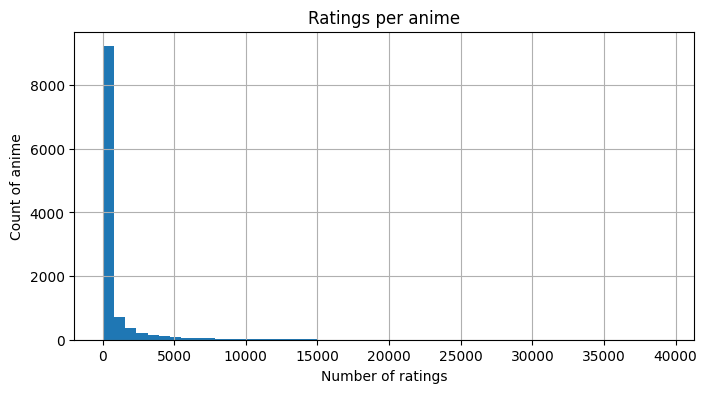

In [23]:
# Ratings per anime distribution
ratings_per_anime = ratings.groupby('anime_id').size()
plt.figure(figsize=(8,4))
plt.hist(ratings_per_anime, bins=50)
plt.title("Ratings per anime")
plt.xlabel("Number of ratings")
plt.ylabel("Count of anime")
plt.grid(True)
plt.show()

In [24]:
# Sparsity
n_users = ratings['user_id'].nunique()
n_items = ratings['anime_id'].nunique()
n_observed = len(ratings)
sparsity = 1.0 - (n_observed / (n_users * n_items))
print(f"\nUser count: {n_users}, Item count: {n_items}, Observed: {n_observed}")
print(f"Sparsity: {sparsity:.4f}")


User count: 73515, Item count: 11200, Observed: 7813737
Sparsity: 0.9905


In [25]:
# We'll create a scaled column in [0,1] to train on; keep original for evaluation.
scaler = MinMaxScaler(feature_range=(0,1))
ratings['rating_scaled'] = scaler.fit_transform(ratings[['rating']])

print("\nScaled rating min/max:", ratings['rating_scaled'].min(), ratings['rating_scaled'].max())



Scaled rating min/max: 0.0 1.0


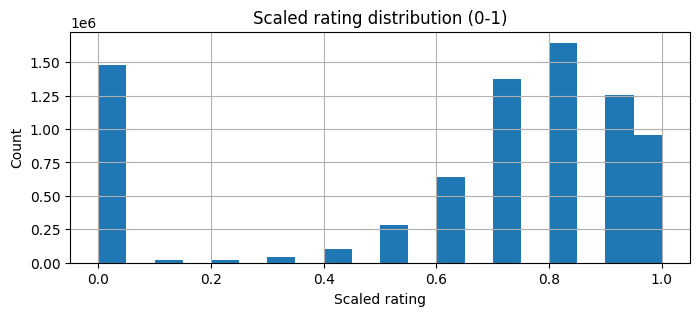

In [26]:
# Visualize scaled distribution
plt.figure(figsize=(8,3))
plt.hist(ratings['rating_scaled'], bins=20)
plt.title("Scaled rating distribution (0-1)")
plt.xlabel("Scaled rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [27]:
C = anime_meta['Rating'].mean()
C

np.float64(6.287866897746967)

In [28]:
anime_meta['ScoredBy'].describe()

count    1.322700e+04
mean     1.139084e+04
std      4.328434e+04
min      1.000000e+00
25%      4.300000e+01
50%      4.780000e+02
75%      3.831000e+03
max      1.006242e+06
Name: ScoredBy, dtype: float64

In [29]:
m = anime_meta['ScoredBy'].quantile(0.85)
m

np.float64(12407.400000000009)

In [30]:
q_animes = anime_meta.copy().loc[anime_meta['ScoredBy'] >= m]
q_animes.shape

(1984, 15)

In [31]:
def weighted_rating(x, m=m, C=C):
    v = x['ScoredBy']
    R = x['Rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
q_animes['Score'] = q_animes.apply(weighted_rating, axis=1)

In [33]:
q_animes = q_animes.sort_values('Score', ascending=False)
q_animes[['Title', 'ScoredBy', 'Rating', 'Score']].head(15)

,Title,ScoredBy,Rating,Score
3634,Fullmetal Alchemist: Brotherhood,730784.0,9.25,9.200548
10110,Kimi no Na wa.,467437.0,9.19,9.114959
5031,Steins;Gate,561405.0,9.14,9.078329
5725,Hunter x Hunter (2011),400879.0,9.11,9.025276
8695,Koe no Katachi,293169.0,9.04,8.928254
3263,Clannad: After Story,362434.0,9.01,8.919896
2461,Code Geass: Hangyaku no Lelouch R2,541989.0,8.95,8.890421
183,Sen to Chihiro no Kamikakushi,496902.0,8.92,8.855878
7747,Shigatsu wa Kimi no Uso,411504.0,8.88,8.804131
10432,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,157302.0,8.99,8.792448


/tmp/ipykernel_8312/1546473177.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=best_score["Title"], y=best_score['Score'], palette="spring_r")


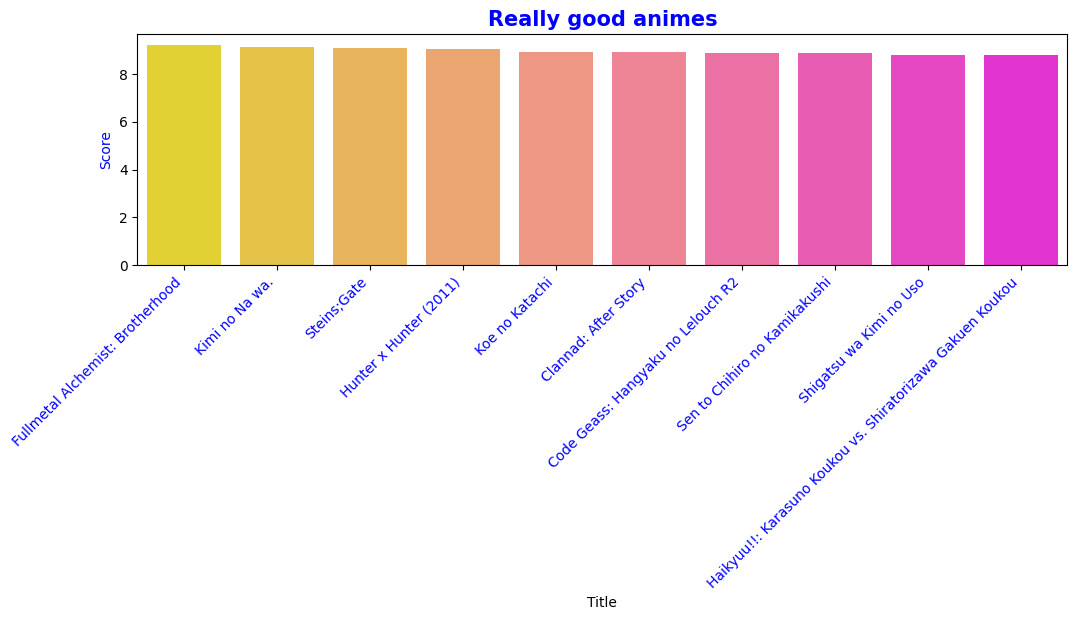

In [34]:
plt.figure(figsize=(12, 3), dpi=100)

best_score = q_animes.sort_values(by=['Score'], ascending=False)[:10]

g = sns.barplot(x=best_score["Title"], y=best_score['Score'], palette="spring_r")
plt.ylabel("Score", color = 'b')
plt.xticks(rotation=45, horizontalalignment='right', color = 'b')
plt.title('Really good animes', fontweight='bold', fontsize=15, color = 'b');

In [35]:
# STEP 5: Train/Validation Split
# -------------------------
train_df, val_df = train_test_split(ratings, test_size=TEST_SIZE, random_state=RANDOM_SEED)
print("\nTrain / Validation sizes:", train_df.shape, val_df.shape)



Train / Validation sizes: (6641676, 4) (1172061, 4)


In [36]:
# STEP 6: Map IDs -> indices
# -------------------------
unique_users = np.union1d(train_df['user_id'].unique(), val_df['user_id'].unique())
unique_items = np.union1d(train_df['anime_id'].unique(), val_df['anime_id'].unique())
user_map = {uid: idx for idx, uid in enumerate(unique_users)}
item_map = {iid: idx for idx, iid in enumerate(unique_items)}
user_map_rev = {v:k for k,v in user_map.items()}
item_map_rev = {v:k for k,v in item_map.items()}

n_users_mapped = len(user_map)
n_items_mapped = len(item_map)
print(f"Mapped users: {n_users_mapped}, Mapped items: {n_items_mapped}")


Mapped users: 73515, Mapped items: 11200


In [37]:
# STEP 7: SGD Matrix Factorization implementation
# -------------------------
class MF_SGD:
    def __init__(self, n_users, n_items, k=20, lr=0.01, reg=0.05, use_bias=True):
        self.n_users = n_users
        self.n_items = n_items
        self.k = k
        self.lr = lr
        self.reg = reg
        self.use_bias = use_bias
        self.P = np.random.normal(scale=0.1, size=(n_users, k))
        self.Q = np.random.normal(scale=0.1, size=(n_items, k))
        if use_bias:
            self.b_u = np.zeros(n_users)
            self.b_i = np.zeros(n_items)
            self.b_global = 0.0

    def predict_raw(self, u_idx, i_idx):
        """Predict on same scale as training (scaled if trained on scaled)"""
        pred = np.dot(self.P[u_idx], self.Q[i_idx])
        if self.use_bias:
            pred += self.b_global + self.b_u[u_idx] + self.b_i[i_idx]
        return pred

    def train(self, train_df, user_map, item_map, val_df=None, epochs=20, use_scaled=True, verbose=True):
        # build list of training triplets (u_idx, i_idx, r)
        triplets = []
        for _, row in train_df.iterrows():
            u_orig = row['user_id']; i_orig = row['anime_id']
            if u_orig in user_map and i_orig in item_map:
                u = user_map[u_orig]; i = item_map[i_orig]
                r = row['rating_scaled'] if use_scaled else row['rating']
                triplets.append((u,i,r))
        if len(triplets) == 0:
            raise ValueError("No training data in mapped indices.")
        if self.use_bias:
            # set initial global bias to mean observed rating
            self.b_global = np.mean([r for (_,_,r) in triplets])

        history = {'train_rmse': [], 'val_rmse': []}
        n = len(triplets)
        for ep in range(1, epochs+1):
            random.shuffle(triplets)
            se = 0.0
            for (u,i,r) in triplets:
                pred = self.predict_raw(u,i)
                err = r - pred
                se += err*err
                # update biases
                if self.use_bias:
                    self.b_u[u] += self.lr * (err - self.reg * self.b_u[u])
                    self.b_i[i] += self.lr * (err - self.reg * self.b_i[i])
                # store old P for Q update
                P_old = self.P[u].copy()
                # update latent factors
                self.P[u] += self.lr * (err * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.lr * (err * P_old - self.reg * self.Q[i])
            train_rmse = math.sqrt(se / n)
            history['train_rmse'].append(train_rmse)

            # validation rmse (on same scale)
            if val_df is not None:
                se_val = 0.0; m = 0
                for _, row in val_df.iterrows():
                    u_orig = row['user_id']; i_orig = row['anime_id']
                    if u_orig in user_map and i_orig in item_map:
                        u = user_map[u_orig]; i = item_map[i_orig]
                        r = row['rating_scaled'] if use_scaled else row['rating']
                        pred = self.predict_raw(u,i)
                        se_val += (r - pred)**2
                        m += 1
                val_rmse = math.sqrt(se_val / m) if m>0 else None
                history['val_rmse'].append(val_rmse)
            else:
                history['val_rmse'].append(None)

            if verbose and (ep==1 or ep%5==0 or ep==epochs):
                print(f"Epoch {ep}/{epochs} - train RMSE: {train_rmse:.5f}" + (f", val RMSE: {val_rmse:.5f}" if val_rmse else ""))

        return history

    def predict(self, user_orig_id, item_orig_id, user_map, item_map):
        if user_orig_id not in user_map or item_orig_id not in item_map:
            return None
        u = user_map[user_orig_id]; i = item_map[item_orig_id]
        return self.predict_raw(u,i)

    def recommend_top_k(self, user_orig_id, user_map, item_map, k=5):
        if user_orig_id not in user_map:
            return []
        u = user_map[user_orig_id]
        preds = []
        for item_orig, i_idx in item_map.items():
            preds.append((item_orig, self.predict_raw(u, i_idx)))
        preds.sort(key=lambda x: x[1], reverse=True)
        return preds[:k]


In [ ]:
# STEP 8: Initialize model and train
# -------------------------
model = MF_SGD(n_users=n_users_mapped, n_items=n_items_mapped, k=K, lr=LR, reg=REG, use_bias=USE_BIAS)
print("\nTraining model with SGD (this may take some time depending on dataset size)...")
history = model.train(train_df, user_map, item_map, val_df=val_df, epochs=EPOCHS, use_scaled=True, verbose=True)



Training model with SGD (this may take some time depending on dataset size)...
Epoch 1/40 - train RMSE: 0.25037, val RMSE: 0.21995
Epoch 5/40 - train RMSE: 0.20192, val RMSE: 0.20306
Epoch 10/40 - train RMSE: 0.20005, val RMSE: 0.20177
Epoch 15/40 - train RMSE: 0.19964, val RMSE: 0.20152


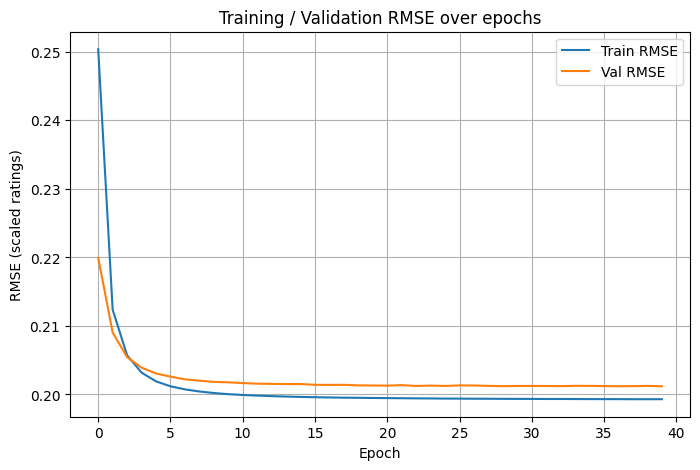

: 

: 

In [ ]:
# STEP 9: Visualize training history
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history['train_rmse'], label='Train RMSE')
if any(v is not None for v in history['val_rmse']):
    plt.plot(history['val_rmse'], label='Val RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE (scaled ratings)")
plt.title("Training / Validation RMSE over epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# STEP 11: Sample recommendations
# -------------------------
print("\nSample recommendations for first 5 users in dataset:")
sample_users = list(unique_users)[:5]
for u_orig in sample_users:
    recs = model.recommend_top_k(u_orig, user_map, item_map, k=5)
    print(f"\nUser {u_orig} top-5 predictions (predicted rating in original scale):")
    for aid, pred_scaled in recs:
        pred_orig = scaler.inverse_transform([[pred_scaled]])[0][0]
        title_row = anime_meta[anime_meta['Anime_id']==aid]
        title = title_row['Title'].values[0] if not title_row.empty else f"Anime_{aid}"
        print(f"  {title} (anime_id={aid}) -> {pred_orig:.2f}")



Sample recommendations for first 5 users in dataset:

User 1 top-5 predictions (predicted rating in original scale):
  Ginga Eiyuu Densetsu (anime_id=820) -> 3.01
  Chieri to Cherry (anime_id=31236) -> 3.01
  Hunter x Hunter (2011) (anime_id=11061) -> 2.70
  Steins;Gate (anime_id=9253) -> 2.67
  Gintama° (anime_id=28977) -> 2.60

User 2 top-5 predictions (predicted rating in original scale):
  Ginga Eiyuu Densetsu (anime_id=820) -> 7.35
  Chieri to Cherry (anime_id=31236) -> 7.23
  Hunter x Hunter (2011) (anime_id=11061) -> 7.02
  Steins;Gate (anime_id=9253) -> 6.99
  Gintama° (anime_id=28977) -> 6.94

User 3 top-5 predictions (predicted rating in original scale):
  Ginga Eiyuu Densetsu (anime_id=820) -> 9.54
  Chieri to Cherry (anime_id=31236) -> 9.47
  Hunter x Hunter (2011) (anime_id=11061) -> 9.23
  Steins;Gate (anime_id=9253) -> 9.21
  Gintama° (anime_id=28977) -> 9.14

User 4 top-5 predictions (predicted rating in original scale):
  Ginga Eiyuu Densetsu (anime_id=820) -> 2.31
  

: 

: 

: 

: 